In [19]:
import pandas as pd
import numpy as np
import json
from pprint import pprint
from IPython.display import clear_output
import os
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path

In [20]:
versions = {
    #"3.9.10":False,
    "nogil-3.9.10-1_0":False,
    "nogil-3.9.10-1_1":False,
    #"3.9.18":False,
    #"3.10.13":False,
    #"3.11.8":False,
    #"3.12.2":False,
}

In [173]:
if os.path.exists("./versions.json"):
    with open("./versions.json","r") as f:
        versions = json.load(f)
        print("loaded")
else:
    with open("./versions.json","w") as f:
        versions_json = json.dumps(versions, indent=4)
        f.write(versions_json)
        print("dumped")

dumped


In [174]:
# Metodo che controlla che ogni versione specificata sia installata sul sistema. 
# Se non lo è la installa, e se il processo di installazione fallisce skippa 
# quella versione rimuovendola dall'elenco di versioni da testare.

def check_versions(versions):
    #print(versions)
    temp = versions.copy()
    for version in temp.keys():
        if not os.path.exists(f"{os.environ['HOME']}/.pyenv/versions/{version}"):
            res = subprocess.run(f"env PYTHON_CONFIGURE_OPTS='--enable-optimizations --with-lto' pyenv install {version}", shell=True)
            if res.returncode != 0:
                versions.pop(version)

In [175]:
check_versions(versions)

In [167]:
# Inizia a raccogliere dati con pyperformance
subprocess.run("pyperf system tune", shell=True)

for version,done in versions.items():
    if done:
        continue
    subprocess.run(f"pyperformance run --python={os.environ['HOME']}/.pyenv/versions/{version}/bin/python -o ./pyperf_res/{version}.json", shell=True)
    versions[version] = True
    with open("./versions.json","w") as f:
        versions_json = json.dumps(versions, indent=4)
        f.write(versions_json)

subprocess.run("pyperf system reset", shell=True)

In [146]:
# Processed files (no warmups)

In [21]:
path = '../results_to_analyse/2024_05_17-16_58_34/single_thread/'
files_to_process = []
for file_name in os.listdir(path):
    if file_name.endswith('.json'):
        files_to_process.append(file_name)

In [22]:
for file in files_to_process:
    f = open(path+file)
    data = json.load(f)
    benchmarks = {}
    for d in data['benchmarks']:
        benchmarks[d['metadata']['name']] = d['runs'][1:]
    for key,val in benchmarks.items():
        for v in val:
            v.pop('warmups')
    json_benchmarks = json.dumps(benchmarks, indent=4)

    new_path = Path(f"{path}processed/")
    new_path.mkdir(parents=True, exist_ok=True)
    # Writing to sample.json
    with open(f"{path}processed/{file.replace('.json','')}_processed.json", "w") as outfile:
        outfile.write(json_benchmarks)

In [23]:
# Create dataframe from processed files

In [24]:
columns = {
    '3.10.13_processed.json':'3.10.13',
    '3.11.8_processed.json':'3.11.8',
    '3.12.2_processed.json':'3.12.2',
    '3.9.18_processed.json':'3.9.18',
    '3.9.10_processed.json':'3.9.10',
    'nogil-3.9.10-1_0_processed.json':'nogil-3.9.10_0',
    'nogil-3.9.10-1_1_processed.json':'nogil-3.9.10_1'
}

In [26]:
path = '../results_to_analyse/2024_05_17-16_58_34/single_thread/processed/'
files = []
for file_name in os.listdir(path):
    print(file_name)
    if file_name.endswith('.json'):
        files.append(file_name)

nogil-3.9.10-1_1_processed.json
nogil-3.9.10-1_0_processed.json


In [27]:
# Get complete list of benchmarks
benchmarks = []
for file in sorted(files):
    f = open(path+file)
    data = json.load(f)
    benchmarks.extend(data.keys())
benchmarks = sorted(list(set(benchmarks)))

In [28]:
df = {}
df['Benchmarks'] = benchmarks

In [29]:
for file in sorted(files):
    print(file)
    all_times = []
    f = open(path+file)
    data = json.load(f)
    for key in benchmarks:
        if data.get(key):
            bench = data[key]
            #pp(bench)
            times = []
            for run in bench:
                vals = run['values']
                times.extend(vals)
            #print(times)
            avg_time = np.average(times)
            all_times.append(round(avg_time,5))
        else:
            all_times.append(np.nan)
    df[columns[file].replace('.json','')] = all_times

nogil-3.9.10-1_0_processed.json
nogil-3.9.10-1_1_processed.json


In [30]:
pd.set_option('display.max_rows', 500)

In [31]:
times_df = pd.DataFrame(df)
columns = [
    'Benchmarks',
    #'3.9.10',
    'nogil-3.9.10_0',
    'nogil-3.9.10_1',
    #'3.9.18',
    #'3.10.13',
    #'3.11.8',
    #'3.12.2'
]
times_df = times_df[columns]
times_df_notnull = times_df.dropna()
times_df_notnull.reset_index(inplace=True, drop = True)
times_df = times_df_notnull
times_df

,Benchmarks,nogil-3.9.10_0,nogil-3.9.10_1
0,2to3,0.25557,0.26465
1,async_generators,0.44250,0.43934
2,async_tree_cpu_io_mixed,0.49683,0.49400
3,async_tree_eager,0.22938,0.22895
4,async_tree_eager_cpu_io_mixed,0.49731,0.49541
5,async_tree_eager_io,0.49614,0.51601
6,async_tree_eager_memoization,0.28195,0.30443
7,async_tree_io,0.49528,0.51662
8,async_tree_memoization,0.28242,0.29204
9,async_tree_none,0.22931,0.22482


In [32]:
times = []
for col in times_df.columns[1:]:
    avg_time = np.average(times_df[col])
    times.append(avg_time)

In [33]:
_2darray = []
row_list = []
for idx, row in times_df.iterrows():
    row_list.append(list(row))
    if len(row_list) == 10:
        _2darray.append(row_list)
        row_list = []

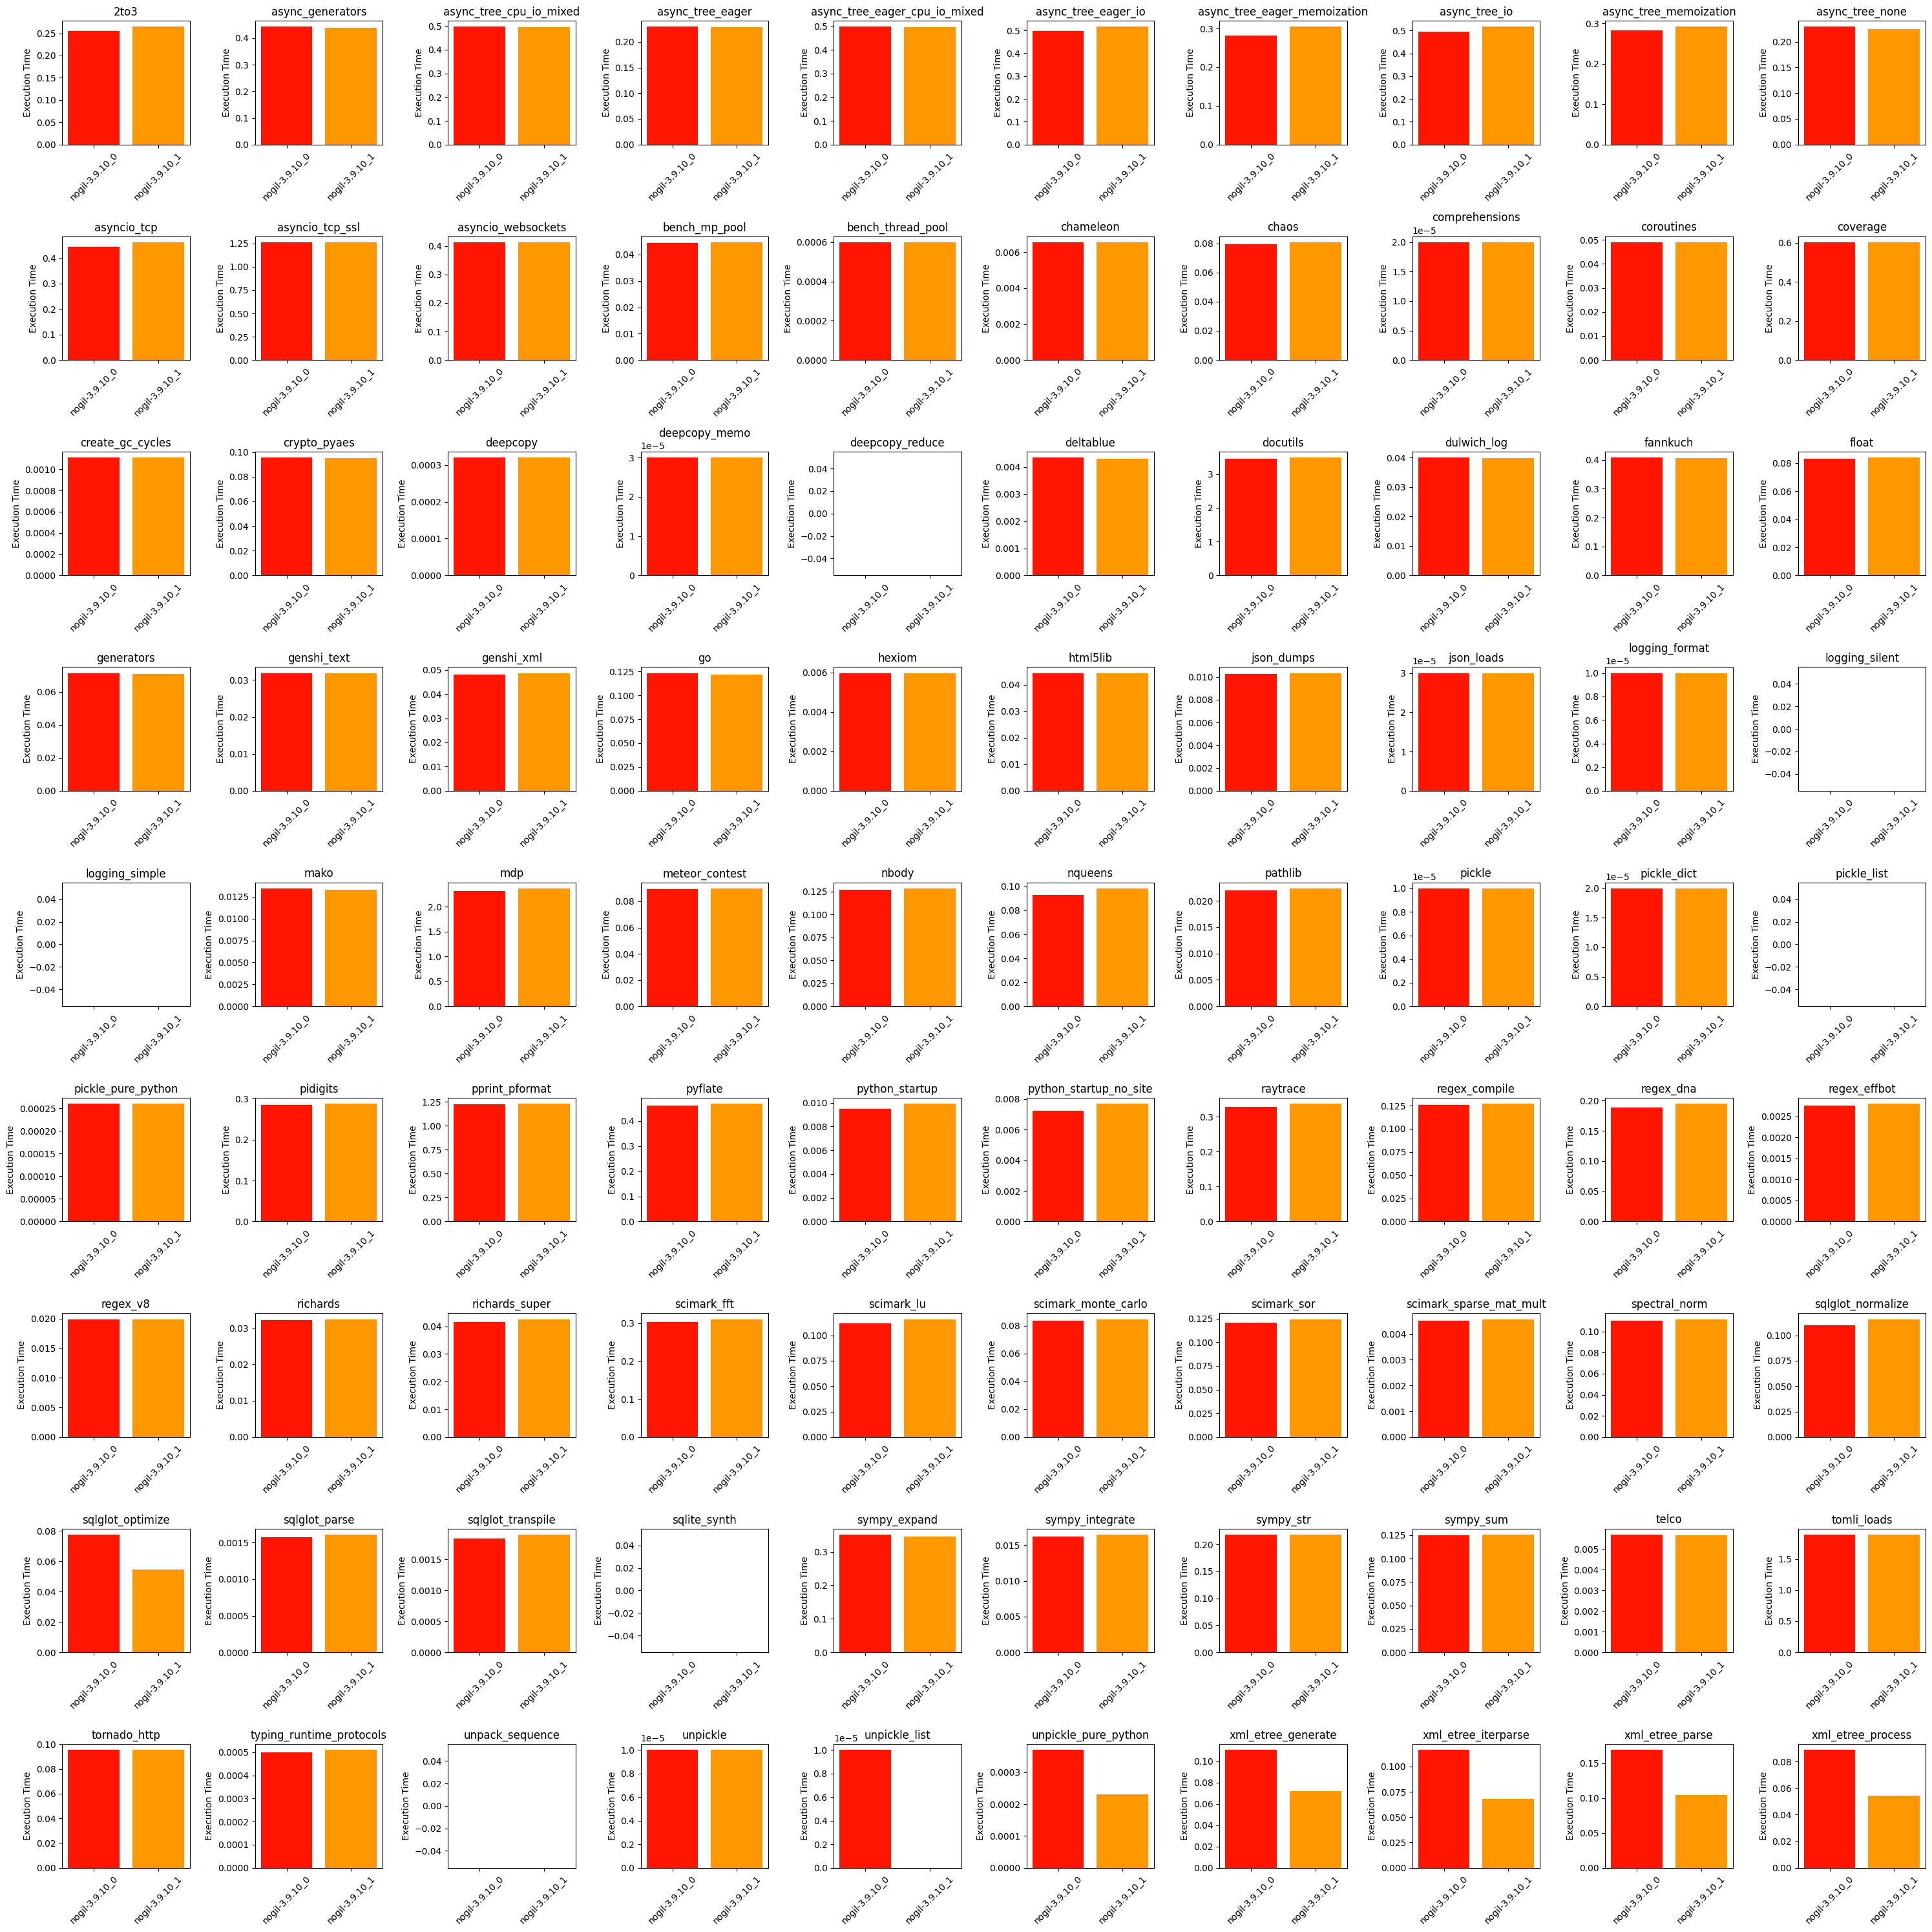

In [40]:
fig, axes = plt.subplots(nrows=9, ncols=10, figsize=(30, 30))

# Loop through each row in the DataFrame
for i in range(10):
    for j in range(9):
        # Create a bar plot for the current benchmark in the corresponding subplot
        ax = axes[j,i]
        benchmark_name = _2darray[j][i][0]  # Extract benchmark name from DataFrame
        benchmark_data = _2darray[j][i][1:]    # Extract benchmark data from DataFrame
        labels = list(times_df.columns)[1:]
        colors = ["#ff1500","#ff9602","#f5cc02","#00d200","#00c3ff","#0022ff"]
        colors = [colors[i] for i in range(len(colors)) if i < len(times_df.columns[1:])]
        #colors.reverse()
        for k, color in enumerate(colors):
            ax.bar(k, benchmark_data[k], color=color)
        ax.set_title(benchmark_name)
        ax.set_ylabel("Execution Time")
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45)
plt.tight_layout()
plt.savefig(f"../results_to_analyse/2024_05_10-19_10_14/single_thread/grafici/all_benchmarks.png", bbox_inches='tight' ,transparent=False, pad_inches=1)
plt.show()

In [41]:
# Processed files (no warmups)

In [42]:
path = '../results_to_analyse/2024_05_17-16_58_34/memory_single_thread/'
files_to_process = []
for file_name in os.listdir(path):
    if file_name.endswith('.json'):
        files_to_process.append(file_name)

In [43]:
processed_files = {}
for file in files_to_process:
    f = open(path + file)
    data = json.load(f)
    benchmarks = {}
    for d in data['benchmarks']:
        benchmarks[d['metadata']['name']] = d['runs'][1:]
    processed_files[f"{file.replace('.json', '')}_processed.json"] = benchmarks

In [44]:
# Create dataframe from processed files

In [45]:
benchmarks = []
for file in sorted(processed_files):
    benchmarks.extend(processed_files[file].keys())
benchmarks = sorted(list(set(benchmarks)))

In [46]:
df = {}
df['Benchmarks'] = benchmarks

In [50]:
columns = {
    '3.10.13_processed.json':'3.10.13',
    '3.11.8_processed.json':'3.11.8',
    '3.12.2_processed.json':'3.12.2',
    '3.9.18_processed.json':'3.9.18',
    '3.9.10_processed.json':'3.9.10',
    'nogil-3.9.10-1_0_processed.json':'nogil-3.9.10_0',
    'nogil-3.9.10-1_1_processed.json':'nogil-3.9.10_1'
}

In [51]:
for file in sorted(processed_files):
        all_mems = []
        data = processed_files[file]
        for key in benchmarks:
            if data.get(key):
                bench = data[key]
                mems = []
                for run in bench:
                    vals = run['values']
                    mems.extend(vals)
                # print(times)
                avg_mem = np.average(mems)
                avg_mem = avg_mem/1024/1024
                all_mems.append(round(avg_mem, 1))
            else:
                all_mems.append(np.nan)
        df[columns[file].replace('.json', '')] = all_mems

In [52]:
pd.set_option('display.max_rows', 500)

In [53]:
mems_df = pd.DataFrame(df)
columns = [
    'Benchmarks',
    #'3.9.10',
    'nogil-3.9.10_0',
    'nogil-3.9.10_1',
    #'3.9.18',
    #'3.10.13',
    #'3.11.8',
    #'3.12.2'
]
mems_df = mems_df[columns]
mems_df_notnull = mems_df.dropna()
mems_df_notnull.reset_index(inplace=True, drop=True)
mems_df = mems_df_notnull
mems_df

,Benchmarks,nogil-3.9.10_0,nogil-3.9.10_1
0,2to3,32.1,32.3
1,async_generators,53.8,54.0
2,async_tree_cpu_io_mixed,219.1,219.1
3,async_tree_io,758.2,758.6
4,async_tree_memoization,234.9,235.1
5,async_tree_none,203.1,203.1
6,asyncio_tcp,80.3,81.0
7,asyncio_tcp_ssl,179.7,155.1
8,asyncio_websockets,60.5,60.9
9,bench_mp_pool,17.2,18.1


In [54]:
_2darray = []
row_list = []
for idx, row in mems_df.iterrows():
    row_list.append(list(row))
    if (idx!=85 and len(row_list) == 10) or idx==85:
        _2darray.append(row_list)
        row_list = []

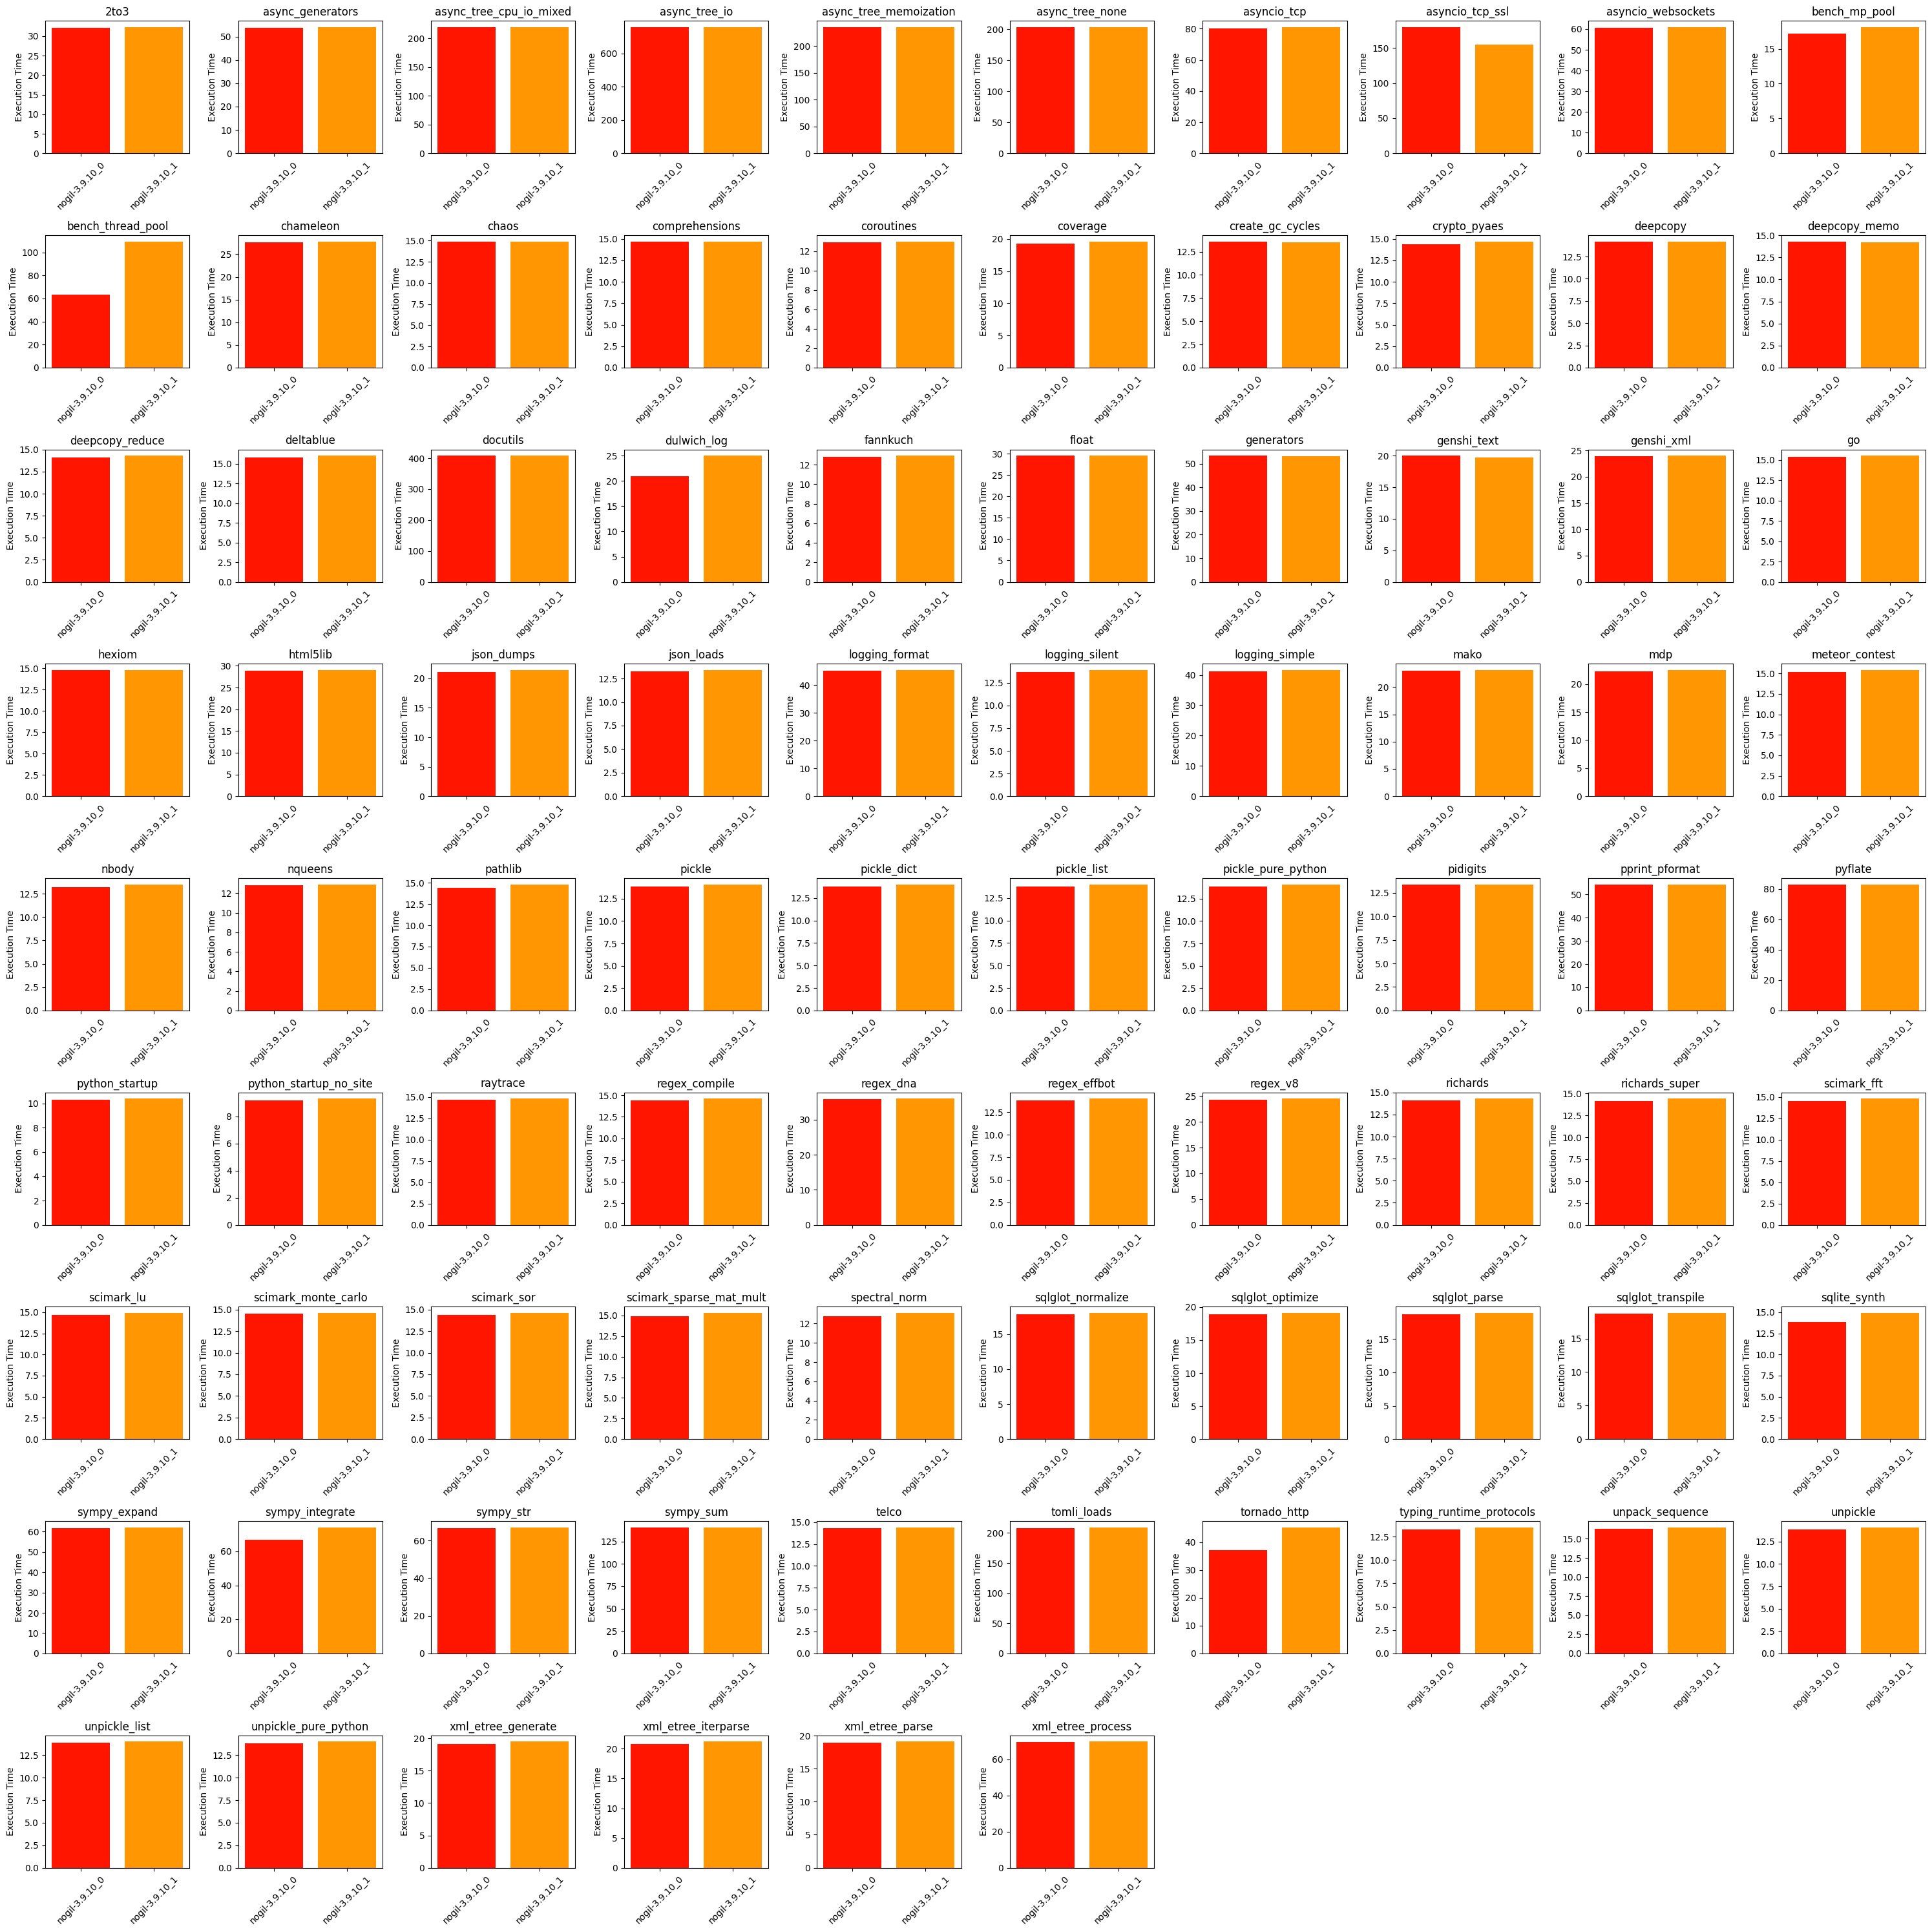

In [55]:
fig, axes = plt.subplots(nrows=9, ncols=10, figsize=(30, 30))

# Loop through each row in the DataFrame
for i in range(10):
    for j in range(9):
        if j==8 and i>5:
            ax = axes[j,i]
            ax.set_visible(False)
        else:
            ax = axes[j,i]
            # Create a bar plot for the current benchmark in the corresponding subplot
            benchmark_name = _2darray[j][i][0]  # Extract benchmark name from DataFrame
            benchmark_data = _2darray[j][i][1:]    # Extract benchmark data from DataFrame
            labels = list(mems_df.columns)[1:]
            colors = ["#ff1500","#ff9602","#f5cc02","#00d200","#00c3ff","#0022ff"]
            colors = [colors[i] for i in range(len(colors)) if i < len(times_df.columns[1:])]
            for k, color in enumerate(colors):
                ax.bar(k, benchmark_data[k], color=color)
            ax.set_title(benchmark_name)
            ax.set_ylabel("Execution Time")
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=45)
plt.tight_layout()
plt.savefig(f"../results_to_analyse/2024_05_10-19_10_14/single_thread/grafici/all_benchmarks_memory.png", bbox_inches='tight' ,transparent=False, pad_inches=1)
plt.show()